In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os 
from IPython.display import display
import scipy.stats as st
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
from get_text import case_names, text, get_df, get_all_df

pd.set_option('display.max_columns', 500)

In [2]:
# Import the master dataframes; one will include stemmed speech while the other will not
df = get_all_df(stemmed='stemmed')
df_no_stem = get_all_df(stemmed='notstemmed')

In [3]:
# script for obtaining the dictionaries for mapping the key:value pairs in the dataframe 
import bs4 as bs
import urllib.request  
import requests
from urllib.parse import urljoin

def get_codes(input_item):

    url_get = ('http://scdb.wustl.edu/documentation.php?var=' + str(input_item))
    sauce = urllib.request.urlopen(str(url_get)).read()
    soup = bs.BeautifulSoup(sauce, 'lxml')

    things = []
    for a in soup.find_all('td'):
        x = a.string
        y = str(x).strip()
        things.append(y)

    stop = (len(things)-15)
    things = things[23:stop]
    new_keys = dict(zip(things[::2], things[1::2]))
    new_keys_two = {int(float(key)):new_keys[key] for key in new_keys}
    return new_keys_two

In [4]:
# Create a master dictionary of these key:value pair mappings 

codes = ['issueArea', 'petitionerState', 'petitioner', 'decisionDirection', 'decisionDirectionDissent',
        'authorityDecision2', 'caseOrigin', 'caseOriginState', 'chief', 'lawType', 'lawSupp', 'declarationUncon',
        'caseDisposition', 'partyWinning', 'caseDisposition', 'precedentAlteration', 'vote', 'opinion', 'direction', 
        'majority']

master_dict = {}

for name in codes:
    master_dict['%s' % name] = get_codes(name)

In [5]:
df['issueAreas'] = df['issueArea'].map(master_dict['issueArea'])
df_no_stem['issueAreas'] = df_no_stem['issueArea'].map(master_dict['issueArea'])
df_no_stem.groupby(['issueAreas']).count().issueArea.sort_values(ascending=False)

issueAreas
Criminal Procedure    218
Economic Activity     159
Civil Rights          134
Judicial Power        106
First Amendment        42
Federalism             40
Due Process            25
Privacy                15
Unions                 14
Attorneys              13
Federal Taxation        9
Miscellaneous           4
Private Action          1
Name: issueArea, dtype: int64

In [6]:
# Isolating Kennedy's Text by Issue Areas with at least 40 cases 

criminal_procedure = df_no_stem[df_no_stem['issueAreas'] == 'Criminal Procedure']
econ_activity = df_no_stem[df_no_stem['issueAreas'] == 'Economic Activity']
civil_rights = df_no_stem[df_no_stem['issueAreas'] == 'Civil Rights']
judicial_power = df_no_stem[df_no_stem['issueAreas'] == 'Judicial Power']
first_amendment = df_no_stem[df_no_stem['issueAreas'] == 'First Amendment']
federalism = df_no_stem[df_no_stem['issueAreas'] == 'Federalism']

## The top 10 words with the most predictive power for each Issue Area according to TF-IDF

#### First, we'll examine all cases together

In [7]:
from itertools import islice
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# IMPORTANT NOTE! Stop words have already been removed 
cvec = CountVectorizer(min_df=1, max_df=.5, ngram_range=(1,2))

In [48]:
# Count vectorizor for TFIDF
cvec_counts = cvec.transform(df.speech)
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)

# Creates a Dataframe with the top 10 most important words per TFIDF
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
2692,well,0.068592
412,case,0.068230
362,but,0.060608
2100,say,0.060101
148,and,0.054110
2784,would,0.051524
648,court,0.040614
2274,state,0.040203
2492,think,0.036744
1299,it,0.036145


#### Next, we'll examine cases involving criminal procedure:

In [8]:
cvec.fit(criminal_procedure.speech)

# Count vectorizor for TFIDF
cvec_counts = cvec.transform(criminal_procedure.speech)
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)

# Creates a Dataframe with the top 10 most important words per TFIDF
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
2054,but,0.022430
16277,would,0.021450
2342,case,0.020366
768,and,0.019847
3690,court,0.016520
14604,think,0.015638
12269,say,0.015428
16542,you,0.014769
11120,question,0.014170
3512,could,0.013927


#### Next, we'll look at cases involving economic activity:

In [9]:
cvec.fit(econ_activity.speech)

# Count vectorizor for TFIDF
cvec_counts = cvec.transform(econ_activity.speech)
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)

# Creates a Dataframe with the top 10 most important words per TFIDF
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
10698,well,0.024514
1704,case,0.023937
11094,would,0.023443
1495,but,0.022980
532,and,0.021537
8323,say,0.015923
2559,court,0.014222
5029,it,0.014178
9905,think,0.013404
889,argument,0.013205


#### What about cases involving civil rights? 

In [10]:
cvec.fit(civil_rights.speech)

# Count vectorizor for TFIDF
cvec_counts = cvec.transform(civil_rights.speech)
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)

# Creates a Dataframe with the top 10 most important words per TFIDF
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
9388,well,0.028886
1250,but,0.025578
544,and,0.024991
9685,would,0.022096
1416,case,0.020977
7335,say,0.019477
9828,you,0.016704
8473,that,0.016283
8665,think,0.015757
7737,so,0.015313


#### Cases involving judicial power? 

In [11]:
cvec.fit(judicial_power.speech)

# Count vectorizor for TFIDF
cvec_counts = cvec.transform(judicial_power.speech)
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)

# Creates a Dataframe with the top 10 most important words per TFIDF
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
874,case,0.028111
6019,well,0.026711
778,but,0.020069
323,and,0.020011
6232,would,0.017417
1415,court,0.016644
4691,say,0.016175
4605,rule,0.015261
2891,it,0.015190
5564,think,0.014047


#### The First Amendment? 

In [12]:
cvec.fit(first_amendment.speech)

# Count vectorizor for TFIDF
cvec_counts = cvec.transform(first_amendment.speech)
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)

# Creates a Dataframe with the top 10 most important words per TFIDF
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
550,but,0.034587
655,case,0.031371
2944,right,0.031348
205,and,0.031080
3912,well,0.025081
3253,speech,0.024517
4021,would,0.023403
1576,government,0.022364
3305,state,0.022358
3337,statute,0.022020


#### And finally, Federalism? 

In [13]:
cvec.fit(federalism.speech)

# Count vectorizor for TFIDF
cvec_counts = cvec.transform(federalism.speech)
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(cvec_counts)

# Creates a Dataframe with the top 10 most important words per TFIDF
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
362,but,0.038402
148,and,0.029328
2692,well,0.028165
2274,state,0.027909
937,federal,0.026864
2234,so,0.026603
412,case,0.026515
2784,would,0.026087
2829,you,0.024443
1817,preemption,0.024013


## To get a baseline of how future ML models are performing, how did Kennedy vote in each Issue Area we're examining?

In [14]:
crim_pet = criminal_procedure[criminal_procedure.winner == 0]
crim_resp = criminal_procedure[criminal_procedure.winner == 1]
crim_total = len(crim_pet) + len(crim_resp)
crim_pet_percent = len(crim_pet) / crim_total
crim_resp_percent = len(crim_resp) / crim_total

print("Justice Kennedy voted with the Petitioner %f percent of the time in cases involving Criminal Procedure" 
      % (crim_pet_percent*100))
print("Justice Kennedy voted with the Respondent %f percent of the time in cases involving Criminal Procedure" 
      % (crim_resp_percent*100))

Justice Kennedy voted with the Petitioner 65.137615 percent of the time in cases involving Criminal Procedure
Justice Kennedy voted with the Respondent 34.862385 percent of the time in cases involving Criminal Procedure


In [15]:
econ_pet = econ_activity[econ_activity.winner == 0]
econ_resp = econ_activity[econ_activity.winner == 1]
econ_total = len(econ_pet) + len(econ_resp)
econ_pet_percent = len(econ_pet) / econ_total
econ_resp_percent = len(econ_resp) / econ_total

print("Justice Kennedy voted with the Petitioner %f percent of the time in cases involving Economic Activity" 
      % (econ_pet_percent*100))
print("Justice Kennedy voted with the Respondent %f percent of the time in cases involving Economic Activity" 
      % (econ_resp_percent*100))

Justice Kennedy voted with the Petitioner 70.063694 percent of the time in cases involving Economic Activity
Justice Kennedy voted with the Respondent 29.936306 percent of the time in cases involving Economic Activity


In [16]:
cr_pet = civil_rights[civil_rights.winner == 0]
cr_resp = civil_rights[civil_rights.winner == 1]
cr_total = len(cr_pet) + len(cr_resp)
cr_pet_percent = len(cr_pet) / cr_total
cr_resp_percent = len(cr_resp) / cr_total

print("Justice Kennedy voted with the Petitioner %f percent of the time in cases involving Civil Rights" 
      % (cr_pet_percent*100))
print("Justice Kennedy voted with the Respondent %f percent of the time in cases involving Civil Rights" 
      % (cr_resp_percent*100))

Justice Kennedy voted with the Petitioner 73.643411 percent of the time in cases involving Civil Rights
Justice Kennedy voted with the Respondent 26.356589 percent of the time in cases involving Civil Rights


In [17]:
jp_pet = judicial_power[judicial_power.winner == 0]
jp_resp = judicial_power[judicial_power.winner == 1]
jp_total = len(jp_pet) + len(jp_resp)
jp_pet_percent = len(jp_pet) / jp_total
jp_resp_percent = len(jp_resp) / jp_total

print("Justice Kennedy voted with the Petitioner %f percent of the time in cases involving Judicial Power" 
      % (jp_pet_percent*100))
print("Justice Kennedy voted with the Respondent %f percent of the time in cases involving Judicial Power" 
      % (jp_resp_percent*100))

Justice Kennedy voted with the Petitioner 58.490566 percent of the time in cases involving Judicial Power
Justice Kennedy voted with the Respondent 41.509434 percent of the time in cases involving Judicial Power


In [18]:
famd_pet = first_amendment[first_amendment.winner == 0]
famd_resp = first_amendment[first_amendment.winner == 1]
famd_total = len(famd_pet) + len(famd_resp)
famd_pet_percent = len(famd_pet) / famd_total
famd_resp_percent = len(famd_resp) / famd_total

print("Justice Kennedy voted with the Petitioner %f percent of the time in cases involving First Amendment Issues" 
      % (famd_pet_percent*100))
print("Justice Kennedy voted with the Respondent %f percent of the time in cases involving First Amendment Issues" 
      % (famd_resp_percent*100))

Justice Kennedy voted with the Petitioner 69.047619 percent of the time in cases involving First Amendment Issues
Justice Kennedy voted with the Respondent 30.952381 percent of the time in cases involving First Amendment Issues


In [19]:
federalism_pet = federalism[federalism.winner == 0]
federalism_resp = federalism[federalism.winner == 1]
federalism_total = len(federalism_pet) + len(federalism_resp)
federalism_pet_percent = len(federalism_pet) / federalism_total
federalism_resp_percent = len(federalism_resp) / federalism_total

print("Justice Kennedy voted with the Petitioner %f percent of the time in cases involving Federalism" 
      % (federalism_pet_percent*100))
print("Justice Kennedy voted with the Respondent %f percent of the time in cases involving Federalism" 
      % (federalism_resp_percent*100))

Justice Kennedy voted with the Petitioner 56.410256 percent of the time in cases involving Federalism
Justice Kennedy voted with the Respondent 43.589744 percent of the time in cases involving Federalism


## Is word count correlated with how Justice Kennedy votes?

To test the difference, we will be analyzing the variance using an unpaired T-test of the data. ANOVA will not be used since we are comparing the mean of 2 samples. 

$\mu_s$: the mean word count when petitioners / plaintiffs win 

$\mu_u$: the mean word count when respondents / defendants win 

$H_0: \mu_s = \mu_u$ (there is no statistical difference between word count when either party wins)

$H_A: \mu_s ≠ \mu_u$ (there is a statistical difference between word count when either party wins)

In [20]:
# Isolate cases based on winner
pet_win = df[(df.winner == 0)]
resp_win = df[(df.winner == 1)]

# Drop NaN values in word count
pets_wcount = pet_win.word_count.dropna()
resp_wcount = resp_win.word_count.dropna()

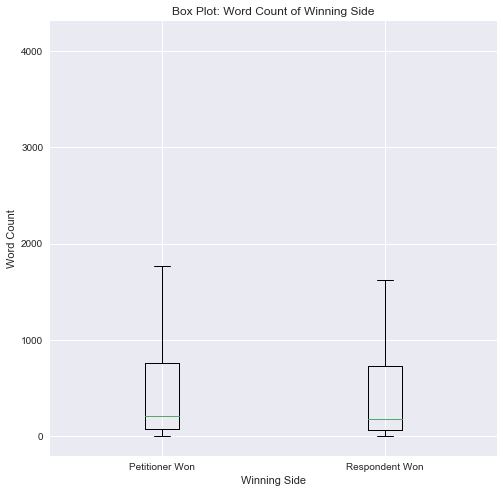

In [49]:
# A box plot to show the data in a different graphical perspective 
data_to_plot1 = [pets_wcount.tolist(), resp_wcount.tolist()]

# Generate the graph 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot1)

# General graph information 
plt.title('Box Plot: Word Count of Winning Side')
plt.xlabel('Winning Side')
plt.ylabel('Word Count')

# Setting the x-label for each dataset 
ax.set_xticklabels(['Petitioner Won', 'Respondent Won'])
plt.show()

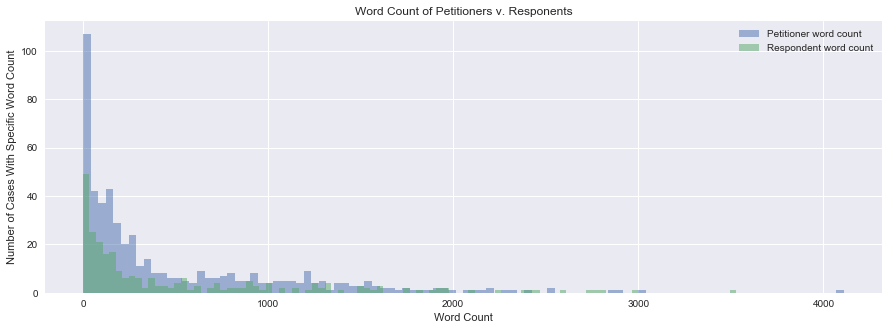

In [23]:
# A histogram of word count by winner

# Drop NaNs from unsold/sold prices DFs
a = pets_wcount
b = resp_wcount

# Create a larger figure to better appreciate the nuances offered from a histogram with a larger number of bins
plt.figure(figsize=(15,5))

# Convert the series to lists in order to overlay them onto a single histogram and label them 
plt.hist(a.tolist(), bins=100, alpha=0.5, label='Petitioner word count')
plt.hist(b.tolist(), bins=100, alpha=0.5, label='Respondent word count')

# Move the legend to the upper right 
plt.legend(loc='upper right')

# Label the histogram, x, and y axes 
plt.title('Word Count of Petitioners v. Responents')
plt.xlabel('Word Count')
plt.ylabel('Number of Cases With Specific Word Count')
plt.show()

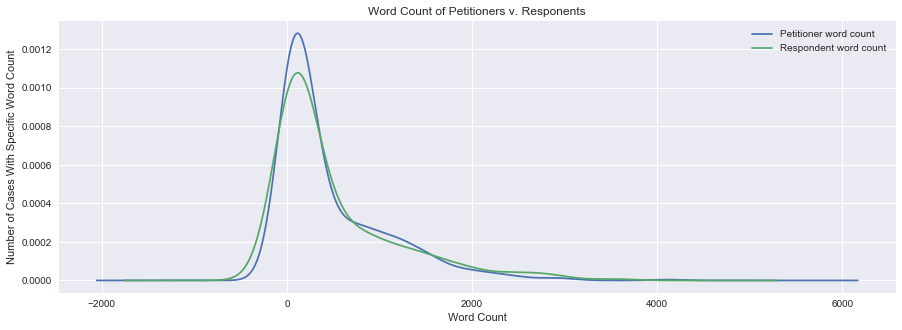

In [24]:
# A kernel density estimation plot to help visualize the word count in another fashion

plt.figure(figsize=(15,5))
a.plot.kde(label='Petitioner word count')
b.plot.kde(label='Respondent word count')
plt.legend(loc='upper right')
plt.title('Word Count of Petitioners v. Responents')
plt.xlabel('Word Count')
plt.ylabel('Number of Cases With Specific Word Count')
plt.show()

In [25]:
# Find the f- and  p- values
fvalue, pvalue = st.f_oneway(pets_wcount, resp_wcount)
display(fvalue, pvalue)

0.36102112694304406

0.54811672306050596

#### Overall, there appears to be only a weak correlation between word count and how Justice Kennedy votes; we should therefore accept the null hypothesis

In [26]:
st.ttest_ind(pets_wcount, resp_wcount, equal_var=False)

Ttest_indResult(statistic=-0.57739494300646033, pvalue=0.56395575593018221)

In [27]:
st.ttest_ind(pets_wcount, resp_wcount, equal_var=True)

Ttest_indResult(statistic=-0.60085033655898379, pvalue=0.54811672306045156)

### However, if we drill down and look at specific issue areas is word count correlated with vote? 

In [28]:
# Criminal procedure

crim_pet = pet_win[(pet_win['issueAreas'] == 'Criminal Procedure')]
crim_resp = resp_win[(resp_win['issueAreas'] == 'Criminal Procedure')]

# Drop NaN values
crim_pets_wcount = crim_pet.word_count.dropna()
crim_resp_wcount = crim_resp.word_count.dropna()

# Find the f- and  p- values
fvalue, pvalue = st.f_oneway(crim_pets_wcount, crim_resp_wcount)
display(fvalue, pvalue)

0.14878228821551884

0.70008139196589347

In [29]:
# Economic Activity

econ_pet = pet_win[(pet_win['issueAreas'] == 'Economic Activity')]
econ_resp = resp_win[(resp_win['issueAreas'] == 'Economic Activity')]

# Drop NaN values
econ_pets_wcount = econ_pet.word_count.dropna()
econ_resp_wcount = econ_resp.word_count.dropna()

# Find the f- and  p- values
fvalue, pvalue = st.f_oneway(econ_pets_wcount, econ_resp_wcount)
display(fvalue, pvalue)

1.5651370023103621

0.21279968014797787

In [30]:
# Civil Rights

cr_pet = pet_win[(pet_win['issueAreas'] == 'Civil Rights')]
cr_resp = resp_win[(resp_win['issueAreas'] == 'Civil Rights')]

# Drop NaN values
cr_pets_wcount = cr_pet.word_count.dropna()
cr_resp_wcount = cr_resp.word_count.dropna()

# Find the f- and  p- values
fvalue, pvalue = st.f_oneway(cr_pets_wcount, cr_resp_wcount)
display(fvalue, pvalue)

0.82557077161744086

0.36527742794860807

In [31]:
# Judical Power

jp_pet = pet_win[(pet_win['issueAreas'] == 'Judicial Power')]
jp_resp = resp_win[(resp_win['issueAreas'] == 'Judicial Power')]

# Drop NaN values
jp_pets_wcount = jp_pet.word_count.dropna()
jp_resp_wcount = jp_resp.word_count.dropna()

# Find the f- and  p- values
fvalue, pvalue = st.f_oneway(jp_pets_wcount, jp_resp_wcount)
display(fvalue, pvalue)

0.019267579266441046

0.88987053317702181

In [32]:
# First Amendment 

famd_pet = pet_win[(pet_win['issueAreas'] == 'First Amendment')]
famd_resp = resp_win[(resp_win['issueAreas'] == 'First Amendment')]

# Drop NaN values
famd_pets_wcount = famd_pet.word_count.dropna()
famd_resp_wcount = famd_resp.word_count.dropna()

# Find the f- and  p- values
fvalue, pvalue = st.f_oneway(famd_pets_wcount, famd_resp_wcount)
display(fvalue, pvalue)

0.03027150686366737

0.86275318699859038

In [33]:
# Federalism

federalism_pet = pet_win[(pet_win['issueAreas'] == 'Federalism')]
federalism_resp = resp_win[(resp_win['issueAreas'] == 'Federalism')]

# Drop NaN values
federalism_pets_wcount = federalism_pet.word_count.dropna()
federalism_resp_wcount = federalism_resp.word_count.dropna()

# Find the f- and  p- values
fvalue, pvalue = st.f_oneway(federalism_pets_wcount, federalism_resp_wcount)
display(fvalue, pvalue)

0.47212566242356896

0.49629538249145622

### For all cases, we must accept the null hypothesis; there is no statistically significant correlation between how Justice Kennedy votes and his word count

# Let's examine the correlation between word count and days to case decision

In [34]:
arg_date = df.dateArgument
arg_date = pd.to_datetime(pd.Series(arg_date))

dec_date = df.dateDecision
dec_date = pd.to_datetime(pd.Series(dec_date))

df['days_to_decision'] = dec_date - arg_date 
days = df['days_to_decision'].dt.days.dropna()

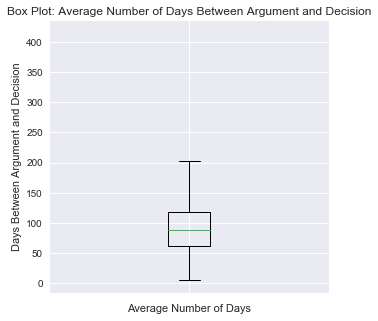

In [35]:
# A box plot to show the data in a different graphical perspective 
data_to_plot2 = days.tolist()

# Generate the graph 
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot2)

# General graph information 
plt.title('Box Plot: Average Number of Days Between Argument and Decision')
plt.xlabel('Average Number of Days')
plt.ylabel('Days Between Argument and Decision')

# Setting the x-label for each dataset 
ax.set_xticklabels([''])
plt.show()

In [36]:
# Isolate cases based on winner
pet_win = df[(df.winner == 0)]
resp_win = df[(df.winner == 1)]

# Drop NaN values in word count
pets_wcount = pet_win.word_count.dropna()
resp_wcount = resp_win.word_count.dropna()

pets_dcount = pet_win.days_to_decision.dropna()
resp_dcount = resp_win.days_to_decision.dropna()

In [37]:
fvalue, pvalue = st.f_oneway(pets_dcount, resp_dcount)
display(fvalue, pvalue)

1.1256840732627122

0.28903177837500005

#### Overall, there appears to be only a weak correlation between word count and days to decision

# General Statistics and Figures for Justice Kennedy

In [38]:
# Get majority type 
df['majority_names'] = df['majority'].map(master_dict['majority'])
majorities = df.majority_names 

# Get vote_names type  
df['vote_names'] = df['vote'].map(master_dict['vote'])
votes = df.vote_names 

# Get liberal/conservative type
df['direction_names'] = df['direction'].map(master_dict['direction'])
directions = df.direction_names 

# Get case origin 
df['caseOrigin_names'] = df['caseOrigin'].map(master_dict['caseOrigin'])
caseOrigins = df.caseOrigin_names 

# Get case state origin
df['caseOriginState_names'] = df['caseOriginState'].map(master_dict['caseOriginState'])
caseOriginStates = df.caseOriginState_names

# Get number of precedent alterations 
df['precedentAlteration_names'] = df['precedentAlteration'].map(master_dict['precedentAlteration'])
precedentAlterations = df.precedentAlteration_names

# Get issue area 
df['issueArea'] = df['issueArea'].map(master_dict['issueArea'])
issueAreas = df.issueArea

# Get Petitioner Type
df['petitioners'] = df['petitioner'].map(master_dict['petitioner'])
petitioners = df.petitioners

# Get Respondent Type
df['respondents'] = df['respondent'].map(master_dict['petitioner'])
respondents = df.respondents

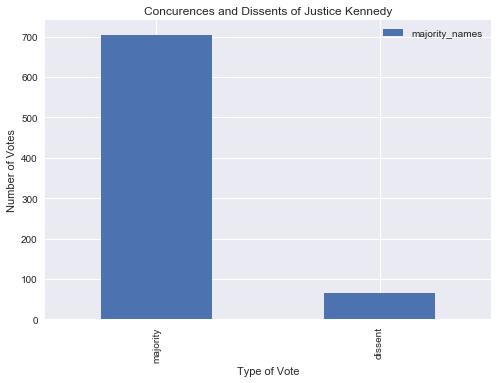

In [39]:
# Plot vote type 
majorities.value_counts().plot(kind='bar')
plt.title('Concurences and Dissents of Justice Kennedy')
plt.xlabel('Type of Vote')
plt.ylabel('Number of Votes')
plt.legend(loc='upper right')
plt.show()

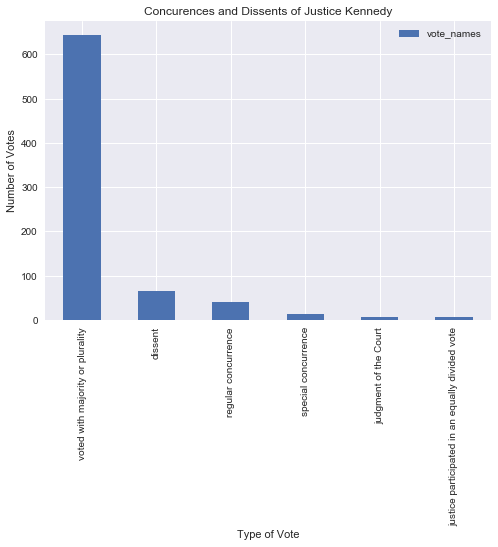

In [40]:
# Plot vote type 
votes.value_counts().plot(kind='bar')
plt.title('Concurences and Dissents of Justice Kennedy')
plt.xlabel('Type of Vote')
plt.ylabel('Number of Votes')
plt.legend(loc='upper right')
plt.show()

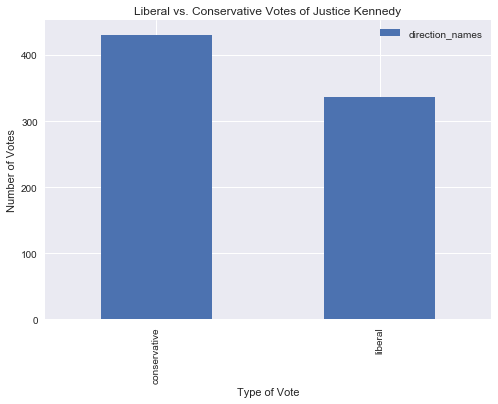

In [41]:
# Plot vote type 
directions.value_counts().plot(kind='bar')
plt.title('Liberal vs. Conservative Votes of Justice Kennedy')
plt.xlabel('Type of Vote')
plt.ylabel('Number of Votes')
plt.legend(loc='upper right')
plt.show()

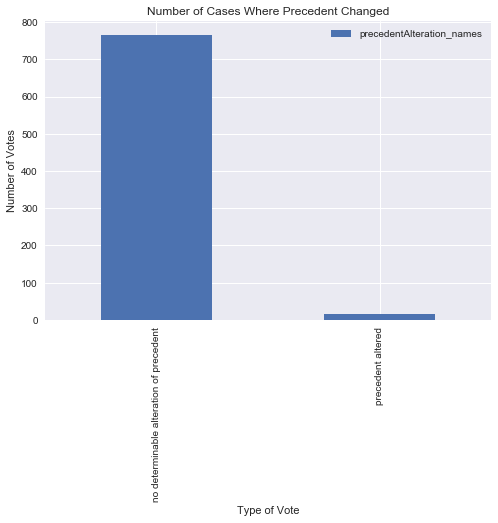

In [42]:
# Plot vote type 
precedentAlterations.value_counts().plot(kind='bar')
plt.title('Number of Cases Where Precedent Changed')
plt.xlabel('Type of Vote')
plt.ylabel('Number of Votes')
plt.legend(loc='upper right')
plt.show()

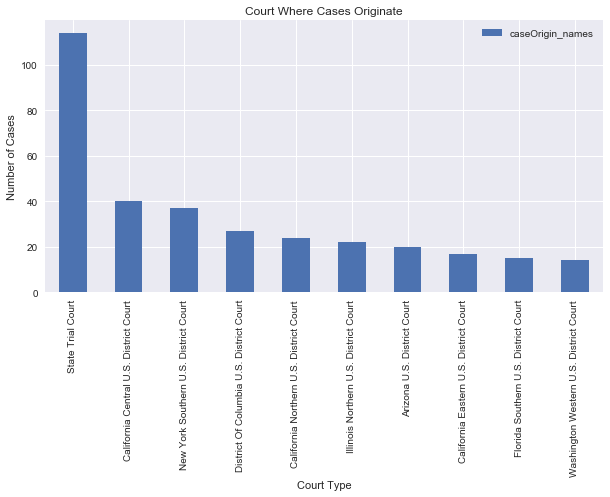

In [43]:
plt.figure(figsize=(10,5))
caseOrigins.value_counts().head(10).plot(kind='bar')
plt.title('Court Where Cases Originate')
plt.xlabel('Court Type')
plt.ylabel('Number of Cases')
plt.legend(loc='upper right')
plt.show()

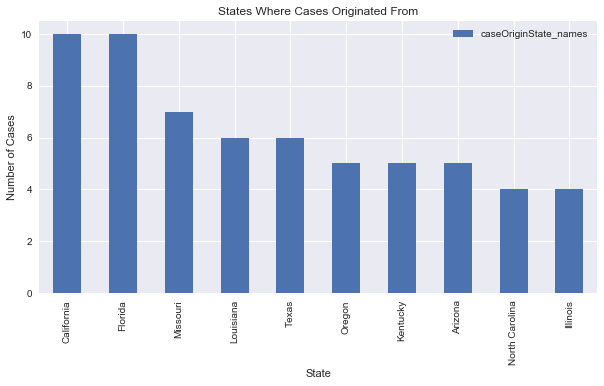

In [44]:
plt.figure(figsize=(10,5))
caseOriginStates.value_counts().head(10).plot(kind='bar')
plt.title('States Where Cases Originated From')
plt.xlabel('State')
plt.ylabel('Number of Cases')
plt.legend(loc='upper right')
plt.show()

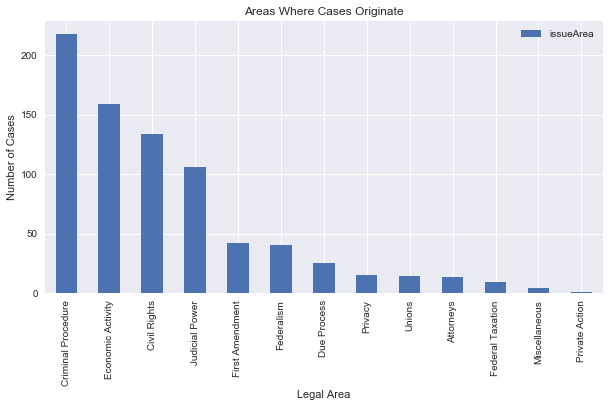

In [45]:
plt.figure(figsize=(10,5))
issueAreas.value_counts().plot(kind='bar')
plt.title('Areas Where Cases Originate')
plt.xlabel('Legal Area')
plt.ylabel('Number of Cases')
plt.legend(loc='upper right')
plt.show()

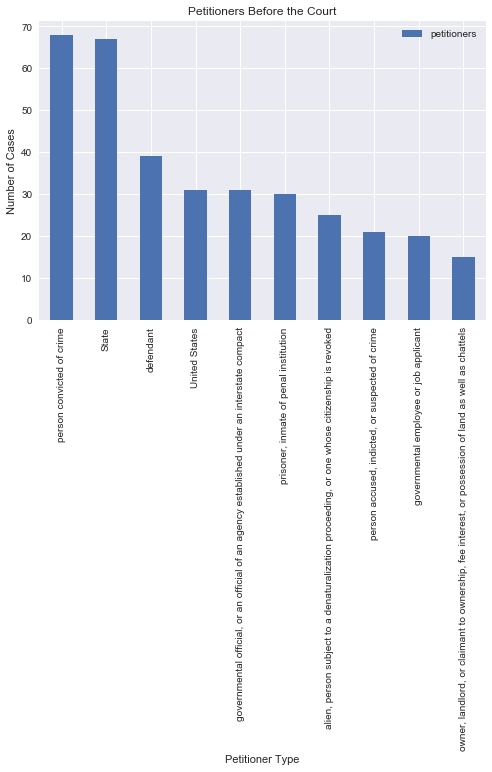

In [46]:
petitioners.value_counts().head(10).plot(kind='bar')
plt.title('Petitioners Before the Court')
plt.xlabel('Petitioner Type')
plt.ylabel('Number of Cases')
plt.legend(loc='upper right')
plt.show()

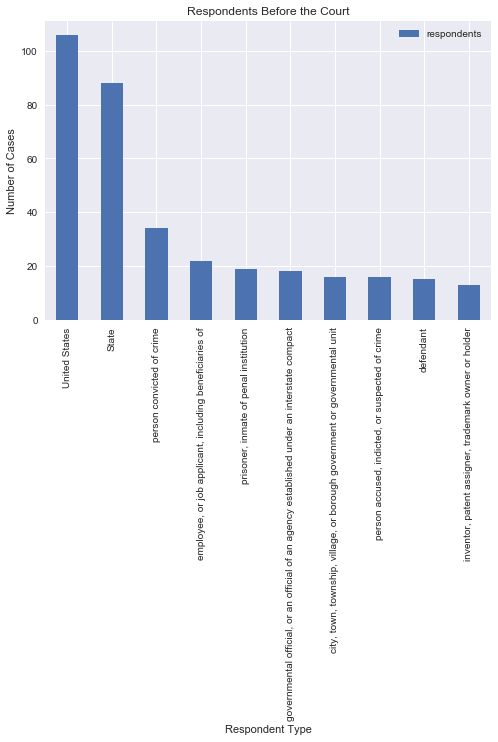

In [47]:
respondents.value_counts().head(10).plot(kind='bar')
plt.title('Respondents Before the Court')
plt.xlabel('Respondent Type')
plt.ylabel('Number of Cases')
plt.legend(loc='upper right')
plt.show()